# RTP Forecasting

In [2]:
# pip install keras-tuner --upgrade

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
import keras_tuner
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [7]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [8]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [9]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [10]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

### Data Preprocessing

In [11]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [12]:
# # Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


### Reshape to (samples, steps, features)

In [13]:
n_steps_in = 24
n_steps_out = 24

x_train_cnn = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn.shape,y_train_cnn.shape,x_test_cnn.shape,y_test_cnn.shape)



(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


In [14]:
minibatch_size = 32
num_epochs     = 50
n_trials       = 10

In [18]:
def build_model(hp):

    hp_neurons = hp.Choice('neurons', values=[16,32,64])
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_kernel_size = hp.Choice('kernel_size', values=[2, 3, 4])
    hp_pool_size = hp.Choice('pool_size', values=[1, 2])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    cnn_model = keras.models.Sequential()
    cnn_model.add(Conv1D(filters=hp_filters,kernel_size=hp_kernel_size, strides=2, padding='same',
                        input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=hp_activation))
    cnn_model.add(Conv1D(filters=hp_filters,kernel_size=hp_kernel_size, strides=2, padding='same',
                        input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=hp_activation))
    cnn_model.add(MaxPooling1D(pool_size=hp_pool_size))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(hp_neurons, activation=hp_activation))
    cnn_model.add(Dense(n_steps_out, activation='linear'))
    cnn_model.summary()
    cnn_model.compile(loss=hp_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return cnn_model

In [23]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='cnn_search6')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 16)            112       
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 16)            528       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 24)                408       
                                                        

In [24]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 7
neurons (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
pool_size (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner.search(x_train_cnn, y_train_cnn, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop],
                    shuffle=False)

Trial 10 Complete [00h 01m 48s]
val_loss: 0.27021634578704834

Best val_loss So Far: 0.19307756423950195
Total elapsed time: 00h 16m 46s


In [26]:
# Initiate an empty dataframe to store your results
tune_res = pd.DataFrame()

# Run a for loop to extract all the information we want
for trial in random_tuner.oracle.trials:
    # Get the state for this trial
    trial_state = random_tuner.oracle.trials[trial].get_state()
    
    # Create a Series contaning the hyperparameter values for this trial
    trial_hyperparameters = pd.Series(
        trial_state["hyperparameters"]["values"],
        index = trial_state["hyperparameters"]["values"].keys())
    
    # Create a Series contaning the validation loss for this trial
    trial_loss = pd.Series(trial_state["score"], index = ["val_loss"])
    
    # Combine both Series into one Series
    trial_tune_res = pd.concat([trial_hyperparameters, trial_loss])
    
    # Name the Series (such that we can trace the trial numbers in the final DataFrame)
    trial_tune_res.name = trial
    
    # Add this trial information to the DataFrame
    tune_res = pd.concat([tune_res, trial_tune_res], axis = 1)
    


# Transpose the DataFrame such that each row represents a trial (optional)
tune_res = tune_res.T

# tune_res

In [27]:
for s in range(n_trials):
    min_idx = s
    for i in range(s + 1, n_trials):
             
            # For sorting in descending order
            # for minimum element in each loop
        if (tune_res["val_loss"][i] < tune_res["val_loss"][min_idx]):
                min_idx = i
 
        # Arranging min at the correct position
    b, c = tune_res.iloc[s].copy(), tune_res.iloc[min_idx].copy()
    temp = tune_res.iloc[s].copy()
    tune_res.iloc[s] = c
    tune_res.iloc[min_idx] = temp


tune_res

,neurons,filters,activation,learning_rate,kernel_size,pool_size,loss,val_loss
00,32,32,tanh,0.001,4,2,mse,0.193078
01,64,32,relu,0.0001,3,1,mse,0.194066
02,64,64,relu,0.00001,4,2,mse,0.20257
03,32,64,tanh,0.001,3,1,mse,0.209496
04,32,16,relu,0.00001,3,2,mse,0.229598
05,32,32,relu,0.001,2,2,mae,0.263423
06,64,64,sigmoid,0.001,2,1,mae,0.270216
07,32,32,tanh,0.01,3,1,mae,0.310589
08,32,64,relu,0.01,3,2,mse,0.370995
09,64,16,sigmoid,0.01,3,1,mse,0.376353


In [28]:
tune_res.to_csv('cnn_tune_res_mini'+str(minibatch_size)+'_'+str(n_steps_in)+'h.csv')

After running all the different random searches, we will only test the best one for the three different look-back windows, and see which is the best in the testing set.

In [23]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [24]:
cnn_model.save(os.path.join(model_path,'cnn_model_dec02.h5'))

### Evaluate

In [25]:
# reload the saved model
cnn_model = load_model(os.path.join(model_path,'cnn_model_nov23.h5'))

y_test_pred = cnn_model.predict(x_test_cnn)


273/273 [==============================] - 0s 881us/step


In [26]:
# Evaluation metrics
errors = y_test_pred - y_test_cnn[:,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4528
RMSE: 0.7121


In [27]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred[::24,:] - y_test_cnn[::24,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4664
RMSE: 0.7242


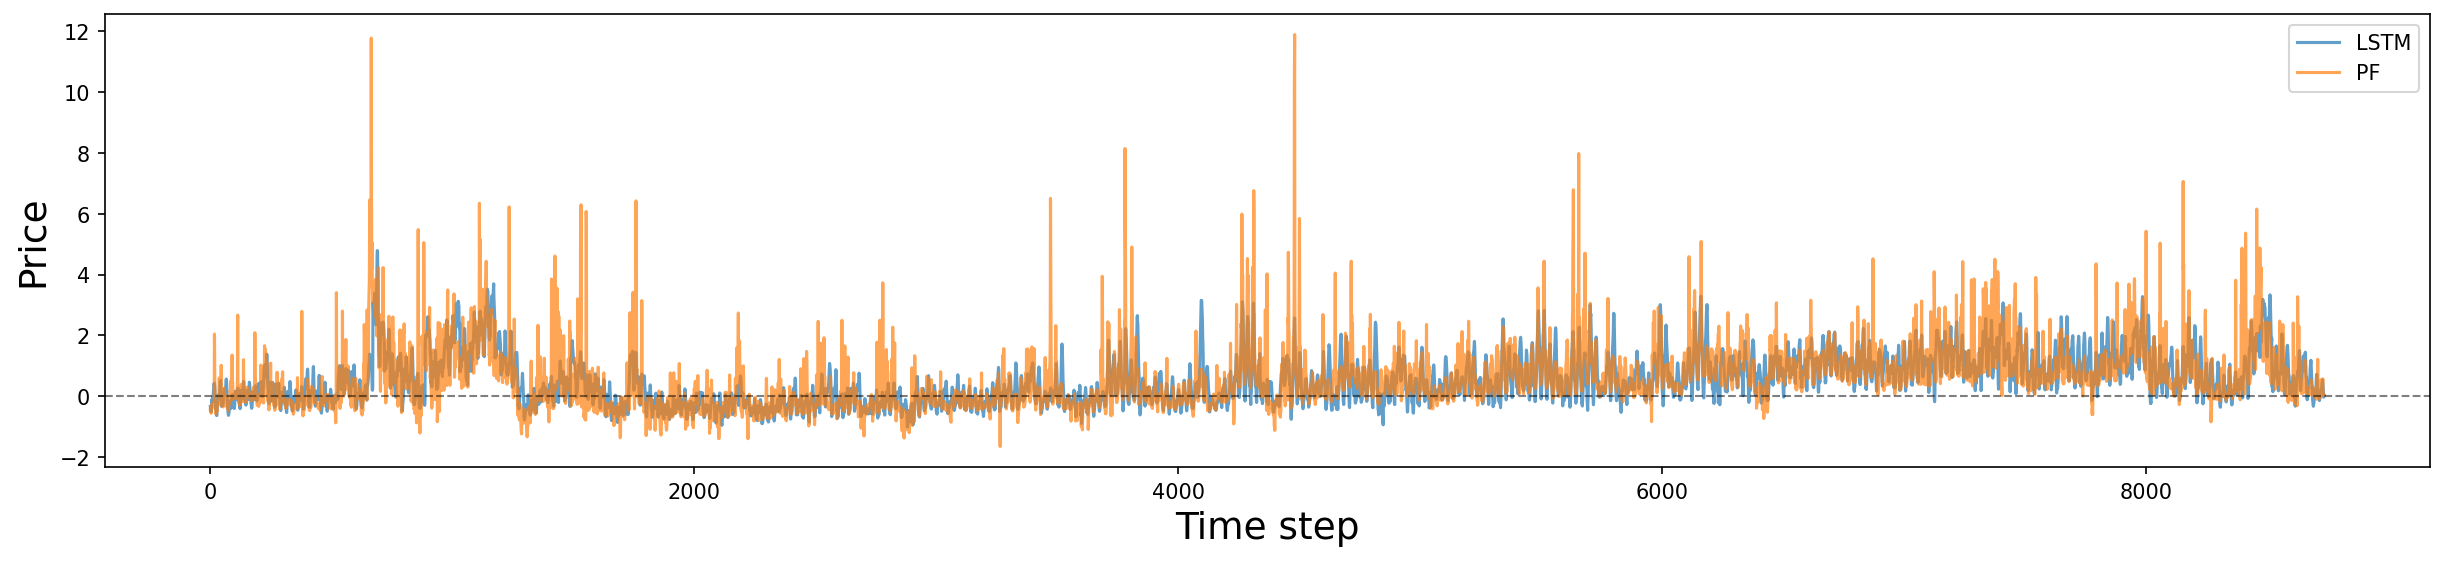

In [125]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_cnn[::24,:,0].flatten(), '')

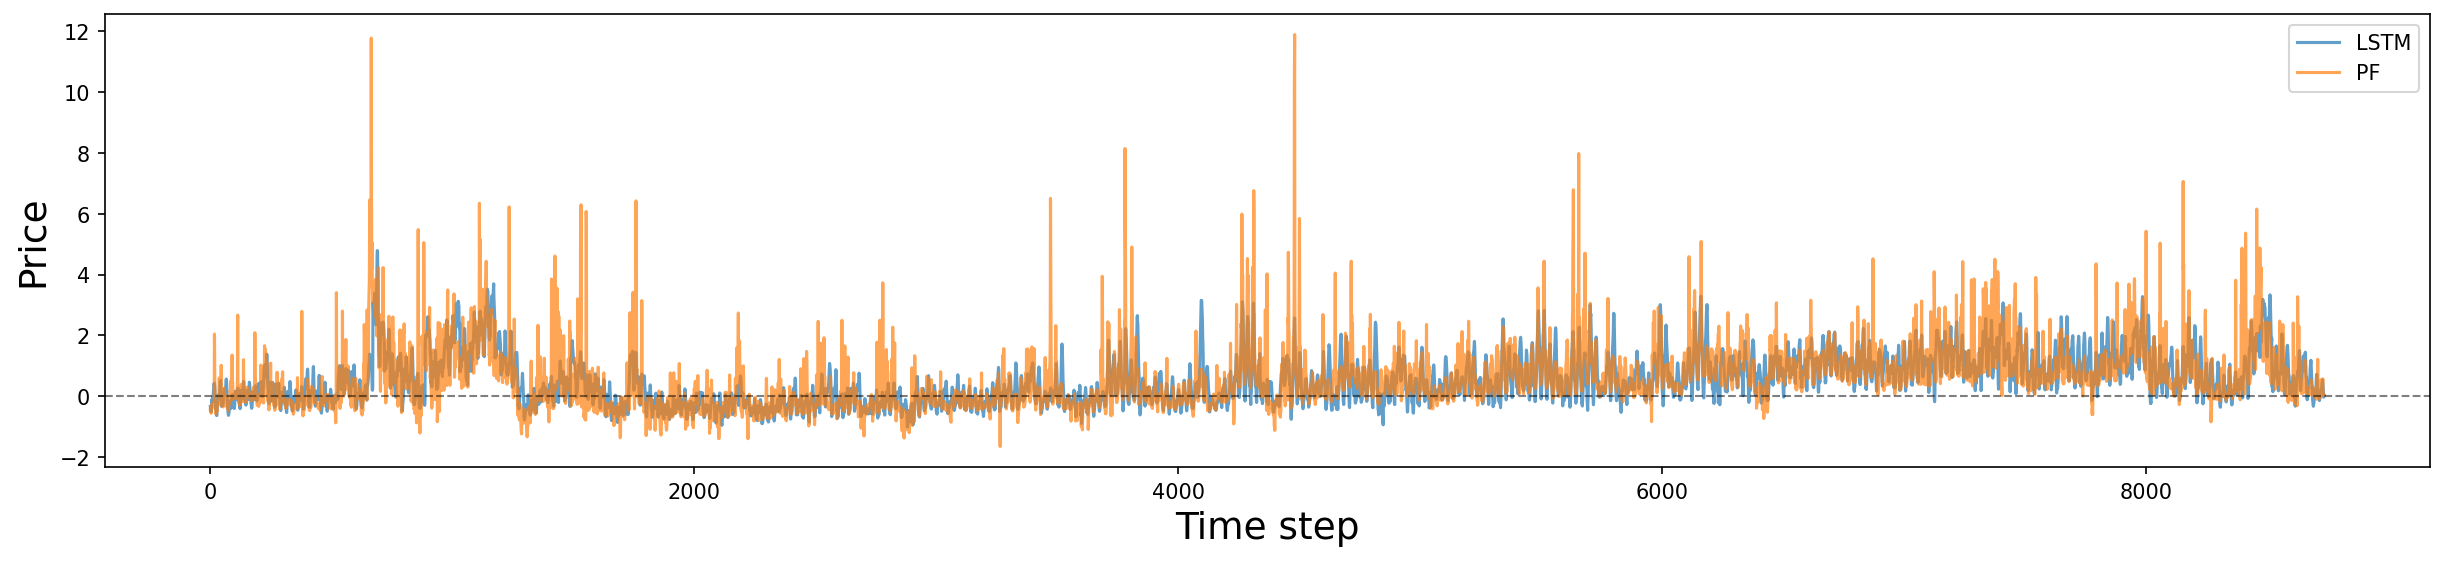

In [126]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_cnn[::24,:,0].flatten(), '')

### Rescale and evaluate performance

In [127]:
y_test_pred_rescale = y_test_pred*y_std.values + y_mean.values
y_test_cnn_rescale = y_test_cnn*y_std.values + y_mean.values

y_test_pred_invlog = np.exp(y_test_pred_rescale) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_invlog = np.exp(y_test_cnn_rescale) -1 + min(raw_data.loc[:,"RTP"])

Hour Ahead Evaluation
MAE: 7.7221
RMSE: 17.3786
24-Hours Ahead Evaluation
MAE: 11.9572
RMSE: 16.8052


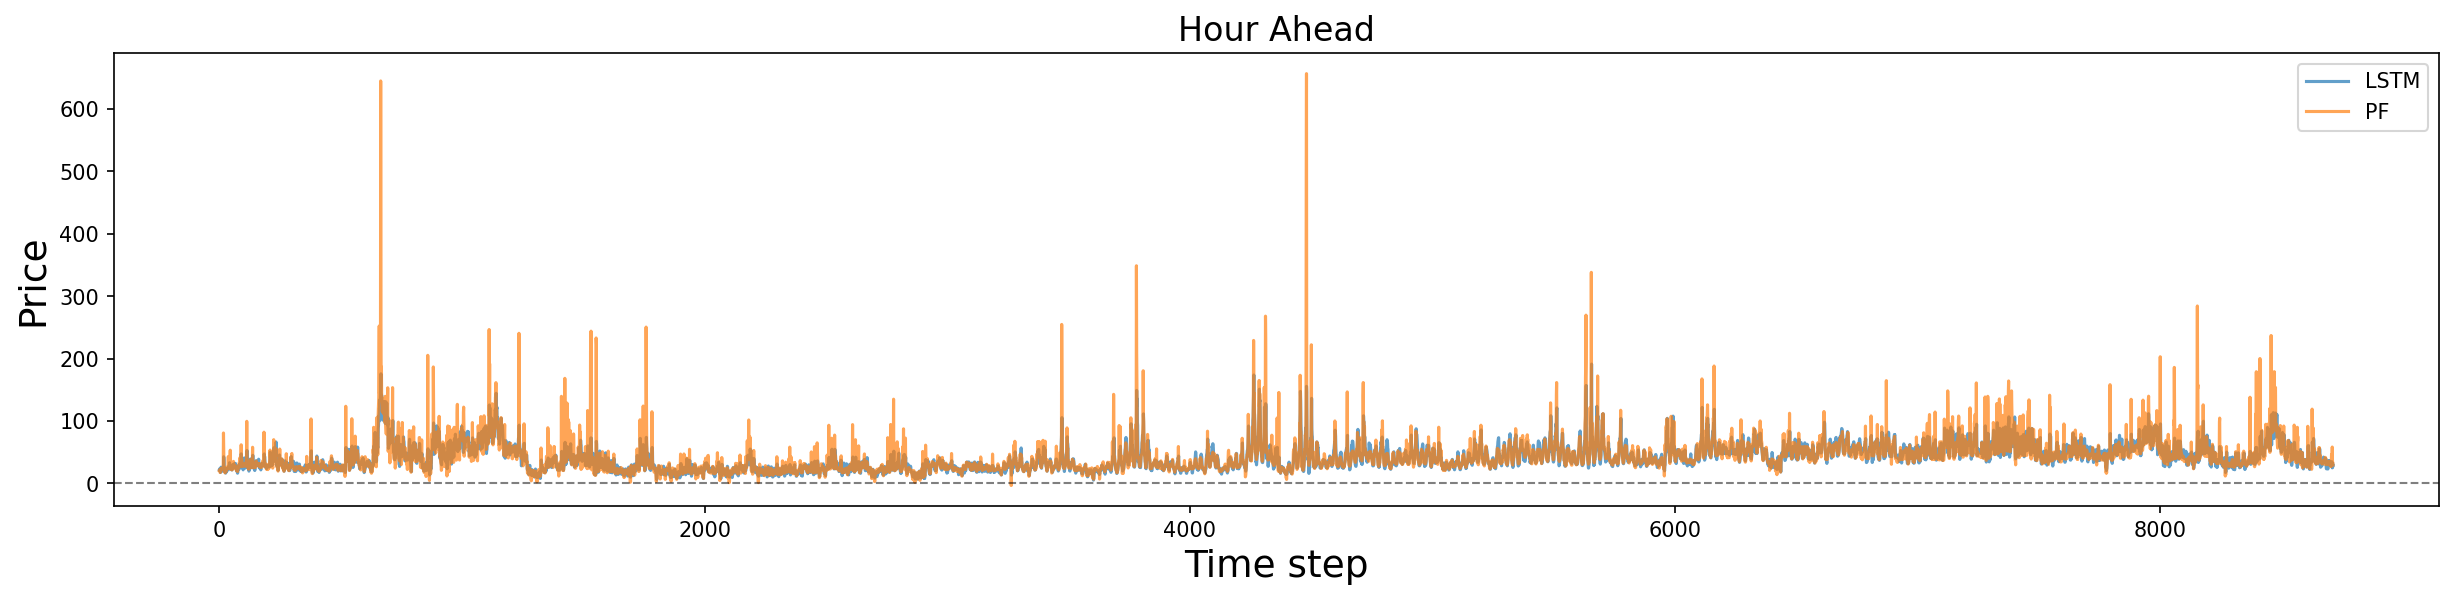

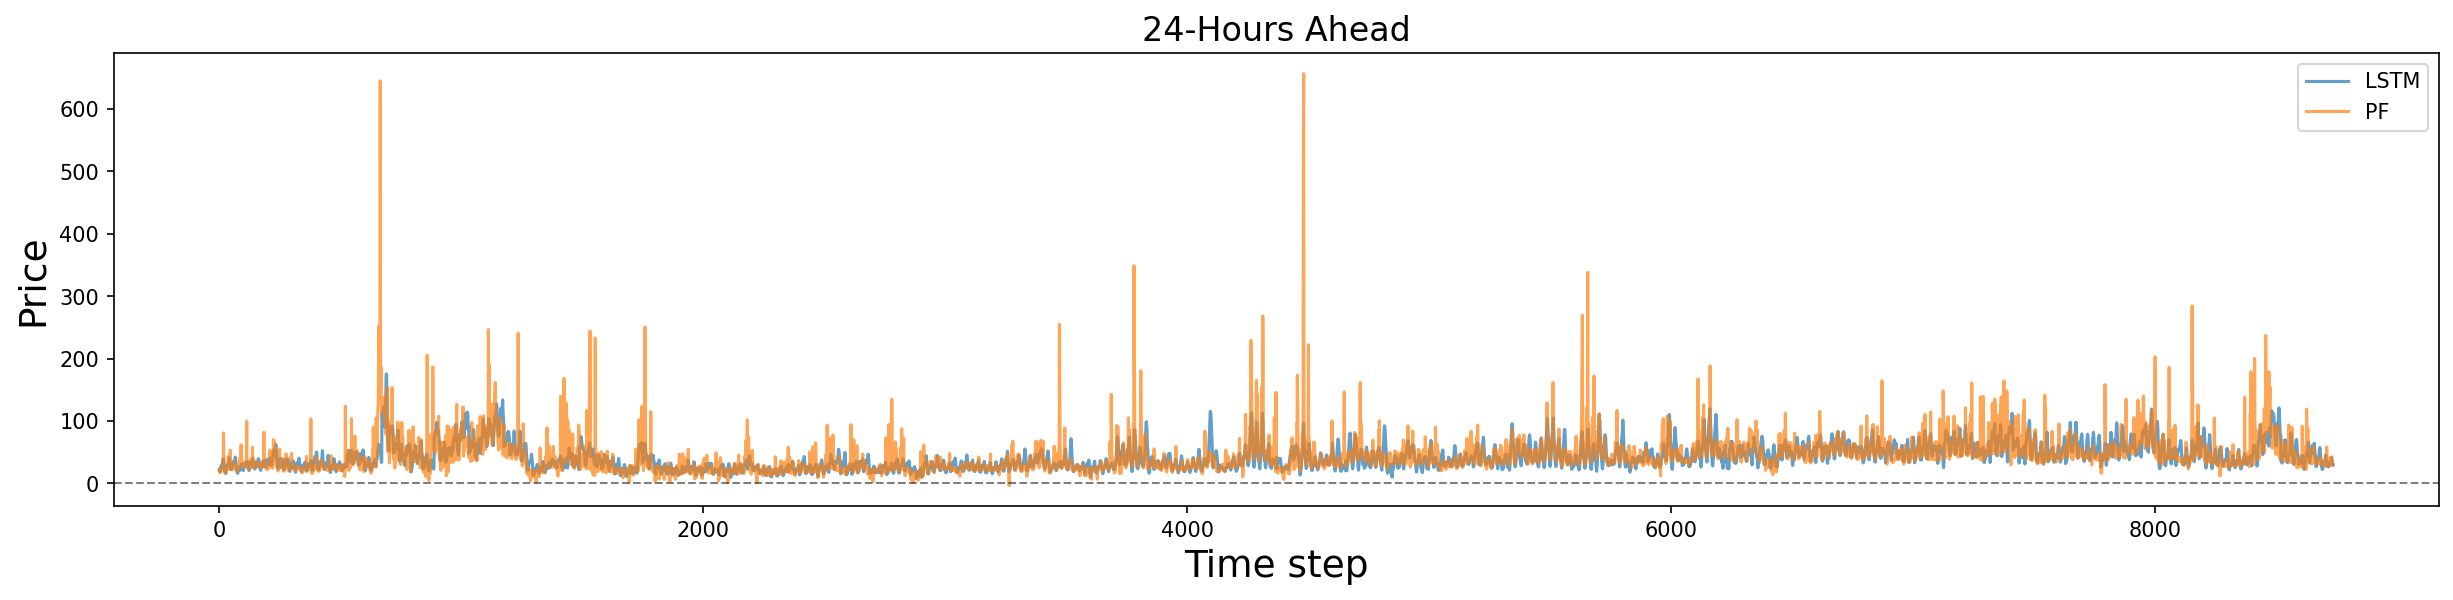

In [128]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_cnn_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_cnn_invlog[::24,0,:]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_cnn_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_cnn_invlog[::24,:,0].flatten(), '24-Hours Ahead')


Hour Ahead Evaluation
MAE: 7.7221
RMSE: 17.3786
24-Hours Ahead Evaluation
MAE: 11.9572
RMSE: 16.8052


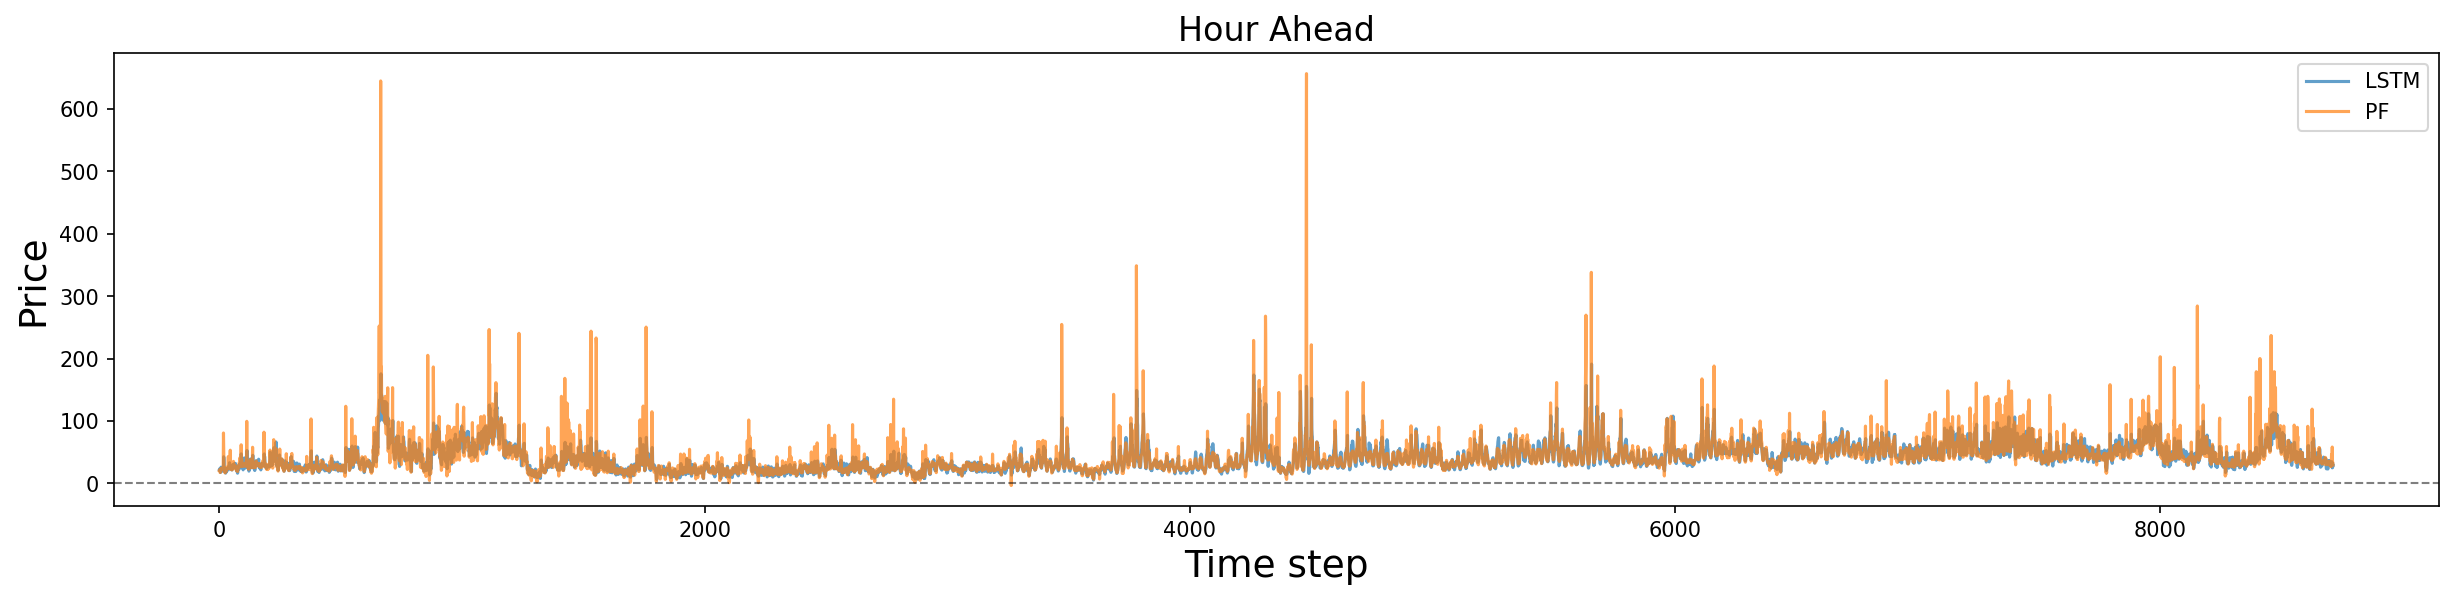

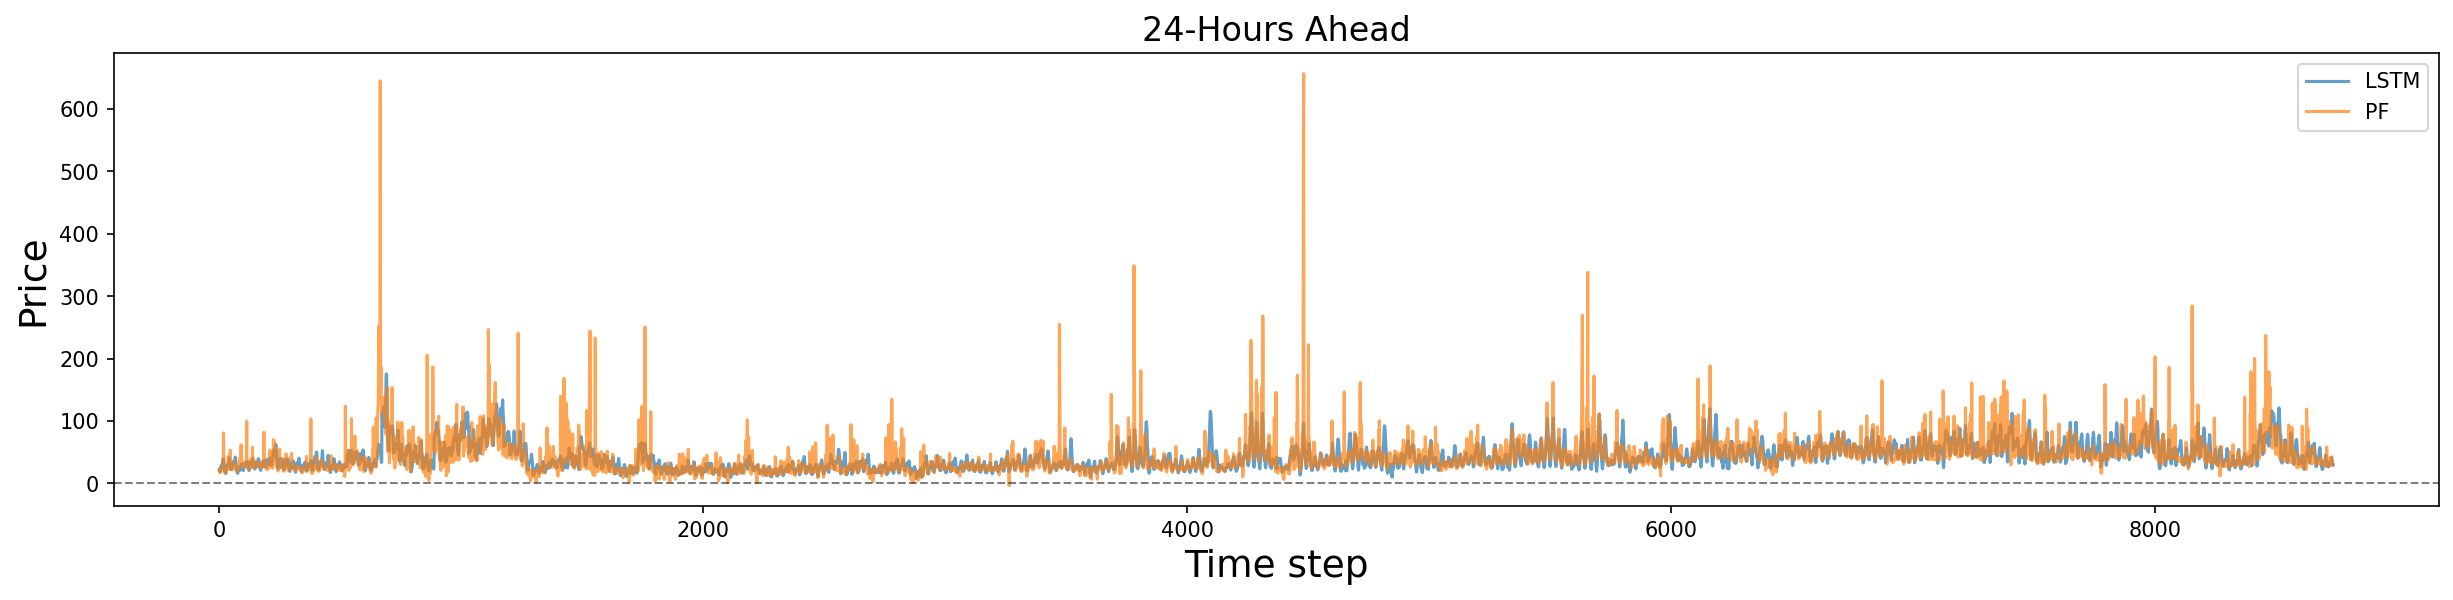

In [129]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_cnn_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_cnn_invlog[::24,0,:]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_cnn_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_cnn_invlog[::24,:,0].flatten(), '24-Hours Ahead')


In [130]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_lstm_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_lstm_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')


NameError: name 'y_test_lstm_invlog' is not defined

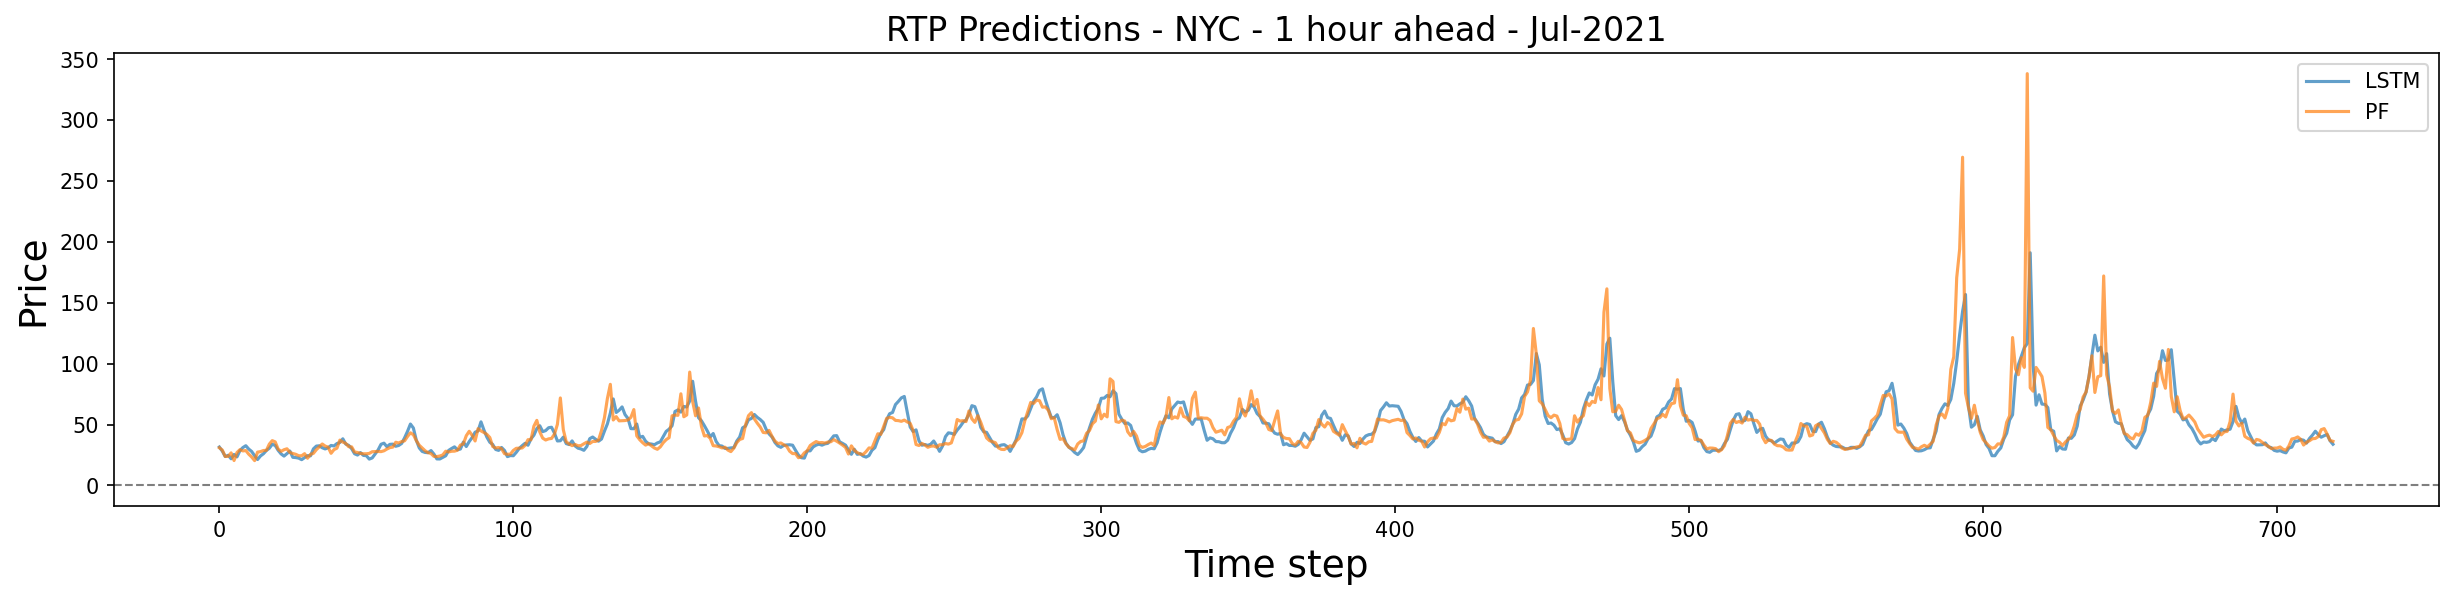

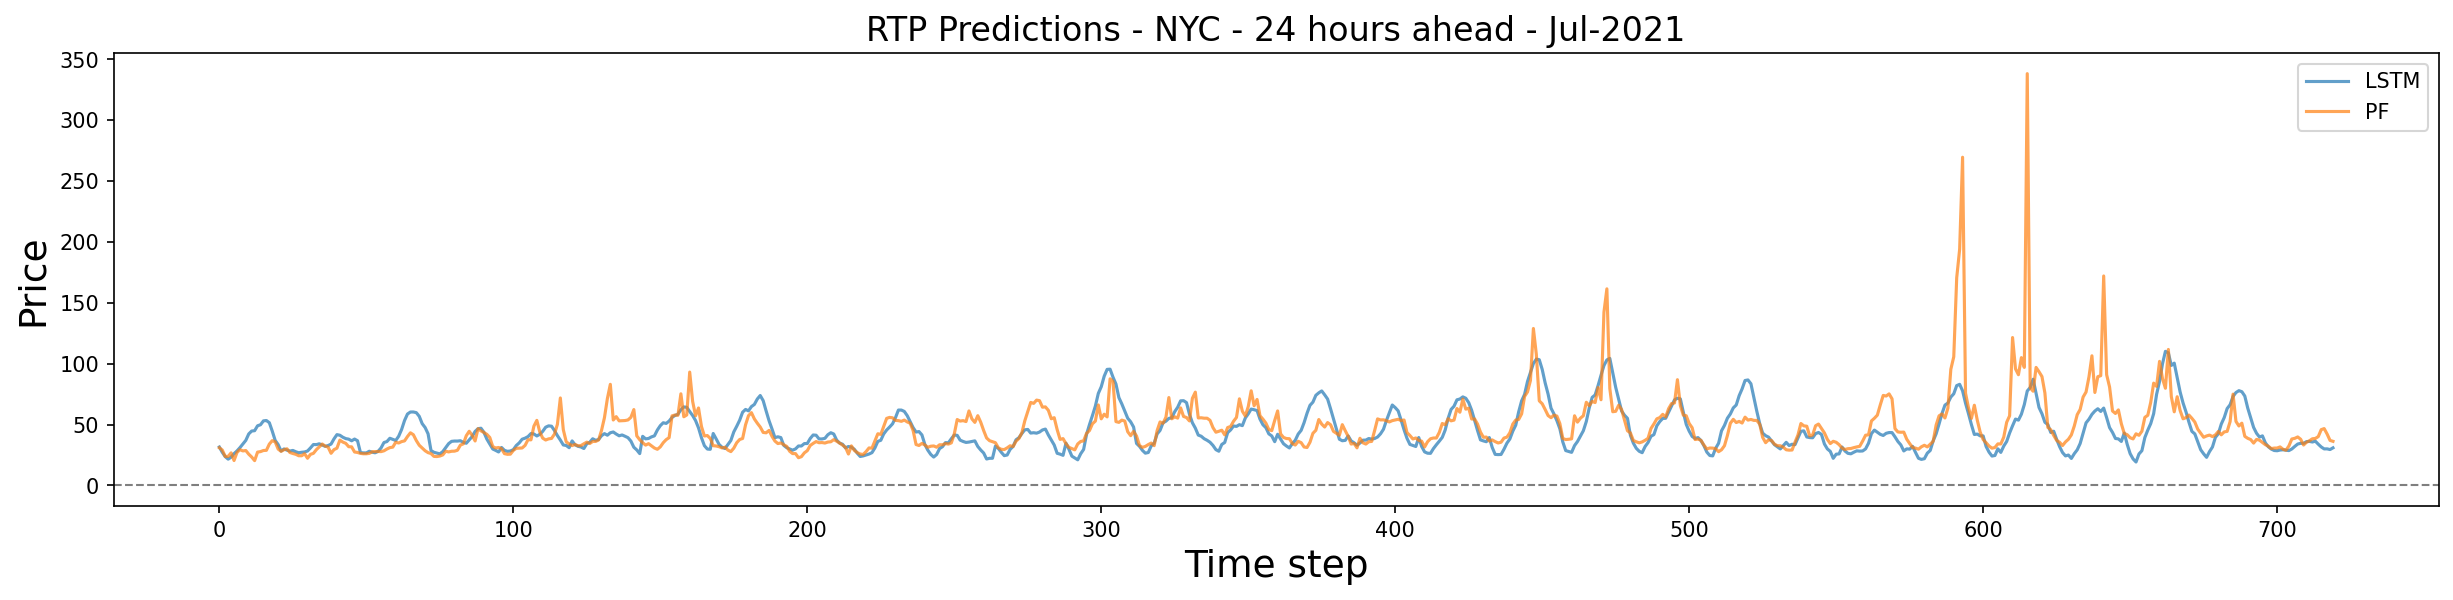

In [132]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_cnn_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_cnn_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')
